C:\Users\a\AppData\Local\Temp\ipykernel_56868\176459862.py:27: DeprecationWarning: Please use atoms.calc = calc
  a.set_calculator(LennardJones(epsilon=0.00262000, sigma=3.4))


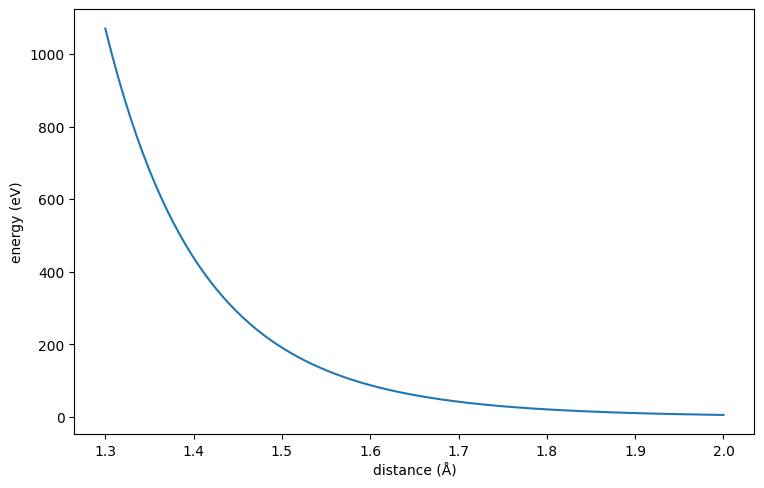

In [113]:
import numpy as np
import ase
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
from dscribe.descriptors import SOAP
from ase.build import graphene

# 设置SOAP描述符
soap = SOAP(
    species=["C"],
    periodic=False,
    r_cut=5.0,
    sigma=0.5,
    n_max=3,
    l_max=0,
)

# 生成Lennard-Jones能量和力的数据集
n_samples = 200
traj = []
n_atoms = 2
energies = np.zeros(n_samples)
forces = np.zeros((n_samples, n_atoms, 3))
r = np.linspace(1.3, 2, n_samples)
for i, d in enumerate(r):
    a = ase.Atoms('CC', positions=[[-0.5 * d, 0, 0], [0.5 * d, 0, 0]]) #选取两个碳原子作为势函数初始构象
    a.set_calculator(LennardJones(epsilon=0.00262000, sigma=3.4))
    traj.append(a)
    energies[i] = a.get_total_energy()
    forces[i, :, :] = a.get_forces()

# 绘制能量图以验证
fig, ax = plt.subplots(figsize=(8, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
line, = ax.plot(r, energies)
plt.xlabel("distance (Å)")
plt.ylabel("energy (eV)")
plt.show()

# 为所有样本创建SOAP描述符及其导数。选择一个中心点在原子之间。
derivatives, descriptors = soap.derivatives(
    traj,
    centers=[[[0, 0, 0]]] * len(r),
    method="analytical"
)

# 保存到磁盘以便后续训练
np.save("r.npy", r)
np.save("E.npy", energies)
np.save("D.npy", descriptors)
np.save("dD_dr.npy", derivatives)
np.save("F.npy", forces)

In [100]:
#使用ase可视化结构
from ase.visualize import view
view(traj)  

In [108]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
torch.manual_seed(7)  # 设置随机种子以确保可重复性

# 加载数据集
D_numpy = np.load("D.npy")[:, 0, :]  # 只使用一个SOAP中心
n_samples, n_features = D_numpy.shape  # 获取样本数量和特征数量
E_numpy = np.array([np.load("E.npy")]).T  # 加载能量数据并转置
F_numpy = np.load("F.npy")  # 加载力数据
dD_dr_numpy = np.load("dD_dr.npy")[:, 0, :, :, :]  # 只使用一个SOAP中心的导数
r_numpy = np.load("r.npy")  # 加载距离数据

# 选择等间距的点用于训练
n_train = 30  # 训练样本数量
idx = np.linspace(0, len(r_numpy) - 1, n_train).astype(int)  # 生成索引
D_train_full = D_numpy[idx]  # 训练特征
E_train_full = E_numpy[idx]  # 训练能量
F_train_full = F_numpy[idx]  # 训练力
r_train_full = r_numpy[idx]  # 训练距离
dD_dr_train_full = dD_dr_numpy[idx]  # 训练导数

# 标准化输入以改善学习。拟合仅在训练数据上进行，
# 标准化应用于训练和测试集的描述符及其导数。
scaler = StandardScaler().fit(D_train_full)  # 拟合标准化器
D_train_full = scaler.transform(D_train_full)  # 标准化训练特征
D_whole = scaler.transform(D_numpy)  # 标准化整个特征集
dD_dr_whole = dD_dr_numpy / scaler.scale_[None, None, None, :]  # 标准化导数
dD_dr_train_full = dD_dr_train_full / scaler.scale_[None, None, None, :]  # 标准化训练导数

# 计算训练集能量和力值的方差。这些用于平衡它们对MSE损失的贡献
var_energy_train = E_train_full.var()  # 计算能量方差
var_force_train = F_train_full.var()  # 计算力方差

# 从验证点中选择20%用于早停
D_train, D_valid, E_train, E_valid, F_train, F_valid, dD_dr_train, dD_dr_valid = train_test_split(
    D_train_full,
    E_train_full,
    F_train_full,
    dD_dr_train_full,
    test_size=0.2,  # 测试集占比
    random_state=7,  # 随机种子
)

# 创建PyTorch张量
D_whole = torch.Tensor(D_whole)  # 转换为张量
D_train = torch.Tensor(D_train)  # 转换为张量
D_valid = torch.Tensor(D_valid)  # 转换为张量
E_train = torch.Tensor(E_train)  # 转换为张量
E_valid = torch.Tensor(E_valid)  # 转换为张量
F_train = torch.Tensor(F_train)  # 转换为张量
F_valid = torch.Tensor(F_valid)  # 转换为张量
dD_dr_train = torch.Tensor(dD_dr_train)  # 转换为张量
dD_dr_valid = torch.Tensor(dD_dr_valid)  # 转换为张量

In [102]:
class FFNet(torch.nn.Module):
    """一个简单的前馈神经网络，具有一个隐藏层，随机初始化权重，
    使用sigmoid激活函数和线性输出层。
    """
    def __init__(self, n_features, n_hidden, n_out):
        super(FFNet, self).__init__()
        self.linear1 = torch.nn.Linear(n_features, n_hidden)  # 第一层线性变换
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=1.0)  # 初始化权重
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid激活函数
        self.linear2 = torch.nn.Linear(n_hidden, n_out)  # 第二层线性变换
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=1.0)  # 初始化权重

    def forward(self, x):
        x = self.linear1(x)  # 通过第一层
        x = self.sigmoid(x)  # 应用激活函数
        x = self.linear2(x)  # 通过第二层

        return x  # 返回输出


def energy_force_loss(E_pred, E_train, F_pred, F_train):
    """自定义损失函数，目标是能量和力。
    """
    energy_loss = torch.mean((E_pred - E_train)**2) / var_energy_train  # 能量损失
    force_loss = torch.mean((F_pred - F_train)**2) / var_force_train  # 力损失
    return energy_loss + force_loss  # 返回总损失


# 初始化模型
model = FFNet(n_features, n_hidden=100, n_out=1)  # 创建前馈神经网络实例

# 使用Adam优化器训练模型参数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # 设置学习率

In [103]:
# 训练模型
n_max_epochs = 5000  # 最大训练轮数
batch_size = 2  # 批次大小
patience = 20  # 早停耐心值
i_worse = 0  # 记录连续未改善的轮数
old_valid_loss = float("Inf")  # 上一轮验证损失
best_valid_loss = float("Inf")  # 最佳验证损失

# 显式要求计算输入变量的梯度
D_valid.requires_grad = True  # 设置验证集的梯度计算

# 训练轮数
for i_epoch in range(n_max_epochs):

    # 批次处理
    permutation = torch.randperm(D_train.size()[0])  # 随机打乱训练数据
    for i in range(0, D_train.size()[0], batch_size):

        indices = permutation[i:i + batch_size]  # 获取当前批次的索引
        D_train_batch, E_train_batch = D_train[indices], E_train[indices]  # 获取当前批次的特征和能量
        D_train_batch.requires_grad = True  # 设置当前批次特征的梯度计算
        F_train_batch, dD_dr_train_batch = F_train[indices], dD_dr_train[indices]  # 获取当前批次的力和导数

        # 前向传播：从描述符输入预测能量
        E_train_pred_batch = model(D_train_batch)  # 预测能量

        # 获取模型输出相对于输入变量的导数
        df_dD_train_batch = torch.autograd.grad(
            outputs=E_train_pred_batch,
            inputs=D_train_batch,
            grad_outputs=torch.ones_like(E_train_pred_batch),
            create_graph=True,  # 创建计算图以便后续计算梯度
        )[0]

        # 获取输入变量（描述符）相对于原子位置的导数（即力）
        F_train_pred_batch = -torch.einsum('ijkl,il->ijk', dD_dr_train_batch, df_dD_train_batch)  # 计算预测力

        # 清零梯度，进行反向传播，并更新权重
        optimizer.zero_grad()  # 清零梯度
        loss = energy_force_loss(E_train_pred_batch, E_train_batch, F_train_pred_batch, F_train_batch)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

    # 检查早停标准并保存最佳模型
    E_valid_pred = model(D_valid)  # 预测验证集能量
    df_dD_valid = torch.autograd.grad(
        outputs=E_valid_pred,
        inputs=D_valid,
        grad_outputs=torch.ones_like(E_valid_pred),
    )[0]
    F_valid_pred = -torch.einsum('ijkl,il->ijk', dD_dr_valid, df_dD_valid)  # 计算验证集预测力
    valid_loss = energy_force_loss(E_valid_pred, E_valid, F_valid_pred, F_valid)  # 计算验证损失
    if valid_loss < best_valid_loss:  # 如果当前验证损失更好
        torch.save(model.state_dict(), "best_model.pt")  # 保存最佳模型
        best_valid_loss = valid_loss  # 更新最佳验证损失
    if valid_loss >= old_valid_loss:  # 如果当前验证损失没有改善
        i_worse += 1  # 增加未改善计数
    else:
        i_worse = 0  # 重置未改善计数
    if i_worse > patience:  # 如果未改善计数超过耐心值
        print("Early stopping at epoch {}".format(i_epoch))  # 输出早停信息
        break  # 结束训练
    old_valid_loss = valid_loss  # 更新旧的验证损失

    if i_epoch % 500 == 0:  # 每500轮输出一次损失
        print("  Finished epoch: {} with loss: {}".format(i_epoch, loss.item()))  # 输出当前轮次和损失

  Finished epoch: 0 with loss: 3.489145517349243
  Finished epoch: 500 with loss: 0.0010001645423471928
  Finished epoch: 1000 with loss: 1.0354653568356298e-05
  Finished epoch: 1500 with loss: 2.519636552733573e-07
  Finished epoch: 2000 with loss: 2.8224026209500153e-06
  Finished epoch: 2500 with loss: 3.1672680051997304e-05
  Finished epoch: 3000 with loss: 1.3390656476985896e-06
  Finished epoch: 3500 with loss: 9.925167432811577e-06
  Finished epoch: 4000 with loss: 9.096237590711098e-06
  Finished epoch: 4500 with loss: 2.8327112886472605e-06


In [104]:
# 告诉PyTorch我们正在进入评估阶段
model.load_state_dict(torch.load("best_model.pt"))  # 加载最佳模型参数
model.eval()  # 设置模型为评估模式

# 计算整个范围的能量和力
E_whole = torch.Tensor(E_numpy)  # 将能量数据转换为张量
F_whole = torch.Tensor(F_numpy)  # 将力数据转换为张量
dD_dr_whole = torch.Tensor(dD_dr_whole)  # 将导数数据转换为张量
D_whole.requires_grad = True  # 设置描述符的梯度计算
E_whole_pred = model(D_whole)  # 预测整个范围的能量

# 获取模型输出相对于输入变量的导数
df_dD_whole = torch.autograd.grad(
    outputs=E_whole_pred,
    inputs=D_whole,
    grad_outputs=torch.ones_like(E_whole_pred),
)[0]

# 计算预测的力
F_whole_pred = -torch.einsum('ijkl,il->ijk', dD_dr_whole, df_dD_whole)  # 计算预测力
E_whole_pred = E_whole_pred.detach().numpy()  # 将预测能量转换为NumPy数组
E_whole = E_whole.detach().numpy()  # 将真实能量转换为NumPy数组

# 保存结果以便后续分析
np.save("r_train_full.npy", r_train_full)  # 保存训练距离数据
np.save("E_train_full.npy", E_train_full)  # 保存训练能量数据
np.save("F_train_full.npy", F_train_full)  # 保存训练力数据
np.save("E_whole_pred.npy", E_whole_pred)  # 保存预测的能量数据
np.save("F_whole_pred.npy", F_whole_pred)  # 保存预测的力数据

C:\Users\a\AppData\Local\Temp\ipykernel_56868\1781024018.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


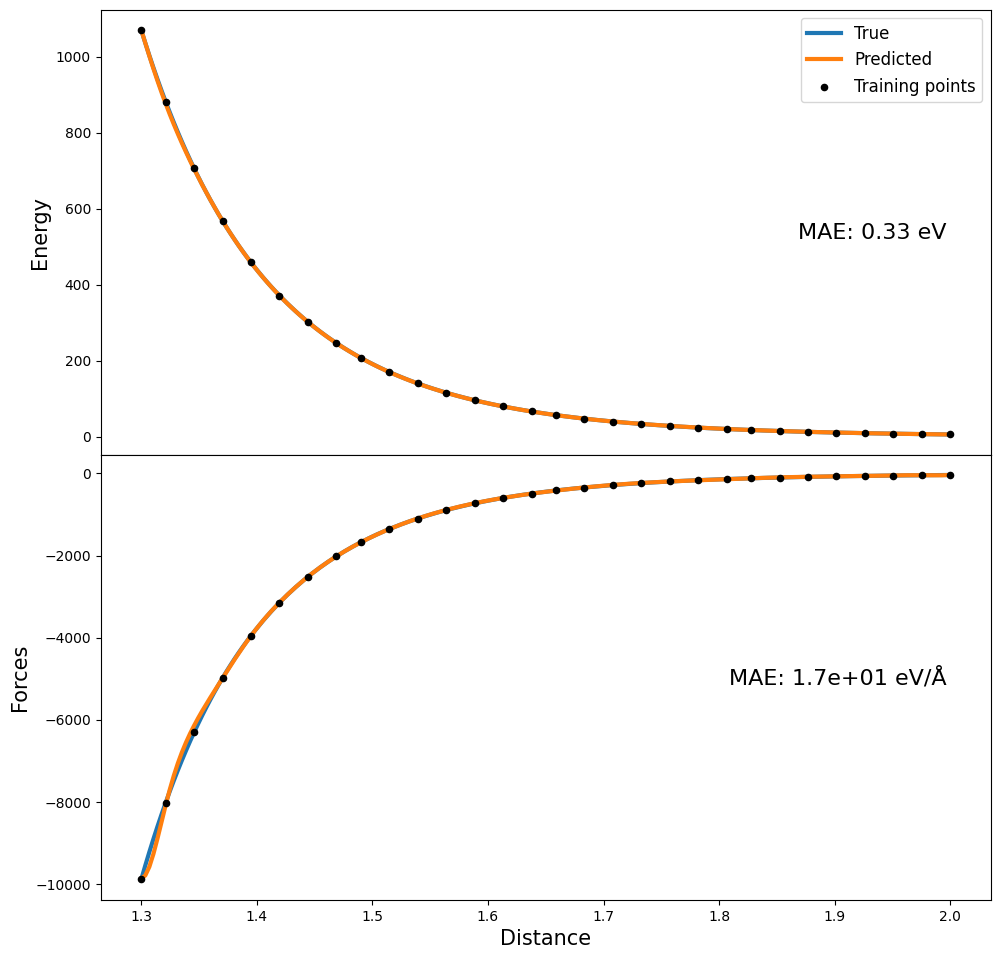

In [109]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

# 加载训练模型生成的数据
r_whole = np.load("r.npy")  # 加载距离数据
r_train_full = np.load("r_train_full.npy")  # 加载训练距离数据
order = np.argsort(r_whole)  # 获取排序索引
E_whole = np.load("E.npy")  # 加载真实能量数据
E_train_full = np.load("E_train_full.npy")  # 加载训练能量数据
E_whole_pred = np.load("E_whole_pred.npy")  # 加载预测能量数据
F_whole = np.load("F.npy")  # 加载真实力数据
F_train_full = np.load("F_train_full.npy")  # 加载训练力数据
F_whole_pred = np.load("F_whole_pred.npy")  # 加载预测力数据
F_x_whole_pred = F_whole_pred[order, 0, 0]  # 获取预测力的x分量
F_x_whole = F_whole[:, 0, 0][order]  # 获取真实力的x分量
F_x_train_full = F_train_full[:, 0, 0]  # 获取训练力的x分量

# 绘制整个范围的能量图
order = np.argsort(r_whole)  # 重新获取排序索引
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))  # 创建两个共享x轴的子图
ax1.plot(r_whole[order], E_whole[order], label="True", linewidth=3, linestyle="-")  # 绘制真实能量
ax1.plot(r_whole[order], E_whole_pred[order], label="Predicted", linewidth=3, linestyle="-")  # 绘制预测能量
ax1.set_ylabel('Energy', size=15)  # 设置y轴标签
mae_energy = mean_absolute_error(E_whole_pred, E_whole)  # 计算能量的平均绝对误差
ax1.text(0.95, 0.5, "MAE: {:.2} eV".format(mae_energy), size=16, horizontalalignment='right', verticalalignment='center', transform=ax1.transAxes)  # 显示MAE

# 绘制整个范围的力图
ax2.plot(r_whole[order], F_x_whole, label="True", linewidth=3, linestyle="-")  # 绘制真实力
ax2.plot(r_whole[order], F_x_whole_pred, label="Predicted", linewidth=3, linestyle="-")  # 绘制预测力
ax2.set_xlabel('Distance', size=15)  # 设置x轴标签
ax2.set_ylabel('Forces', size=15)  # 设置y轴标签
mae_force = mean_absolute_error(F_x_whole_pred, F_x_whole)  # 计算力的平均绝对误差
ax2.text(0.95, 0.5, "MAE: {:.2} eV/Å".format(mae_force), size=16, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes)  # 显示MAE

# 绘制训练点
ax1.scatter(r_train_full, E_train_full, marker="o", color="k", s=20, label="Training points", zorder=3)  # 绘制训练能量点
ax2.scatter(r_train_full, F_x_train_full, marker="o", color="k", s=20, label="Training points", zorder=3)  # 绘制训练力点

# 显示图形
ax1.legend(fontsize=12)  # 添加图例
plt.subplots_adjust(left=0.08, right=0.97, top=0.97, bottom=0.08, hspace=0)  # 调整子图参数
plt.show()  # 显示图形